In [151]:
import csv
import sys
import numpy
import networkx as nx
import pickle
import random
import itertools
import matplotlib.pyplot as plt

In [152]:
'''
performs trip trading algorithm as described in research doc
@:param Graph G - sharability network
@:param float market_split - between 0-1, denoting the share of the market
@:param matching_alg: choose from max_card_matching, max_weight_matching, max_profit_matching 
'''
def trip_trade(G, trip_info, market_split, matching_alg):
    company1, company2 = split_graph(G, market_split)

    max_matching1 = nx.max_weight_matching(company1, weight=matching_alg)
    max_matching2 = nx.max_weight_matching(company2, weight=matching_alg)
    profits1 = calc_profits(company1, max_matching1)
    profits2 = calc_profits(company2, max_matching2)
    VKT1 = calc_VKT(company1, max_matching1, trip_info)
    VKT2 = calc_VKT(company2, max_matching2, trip_info)
    matched_trips1, matched_trips2 = [len(max_matching1)], [len(max_matching2)]
    profits_iter1, profits_iter2 = [profits1], [profits2]
    VKTs1, VKTs2 = [VKT1], [VKT2]
    # add nodes that we need to visit

    to_visit_1 = company1.nodes - set(itertools.chain(*max_matching1))
    to_visit_2 = company2.nodes - set(itertools.chain(*max_matching2))

#     print("matched trips 1:", matched_trips1)
#     print("matched trips 2: ", matched_trips2)
#     print("profits 1:", profits1)
#     print("profits 2:", profits2)
    iters = 0

    while to_visit_1 and to_visit_2:
#         print("iter:", iters)
        if to_visit_1:
#             print('A -> B')
            company1, company2 = do_iteration(G, company1, company2, to_visit_1, max_matching1, max_matching2,  trip_info, matching_alg,\
                                              [matched_trips1, matched_trips2], [profits_iter1, profits_iter2], [VKTs1, VKTs2])
        if to_visit_2:
#             print('B -> A')
            company2, company1 = do_iteration(G, company2, company1, to_visit_2, max_matching2, max_matching1, trip_info, matching_alg, \
                                              [matched_trips2, matched_trips1], [profits_iter2, profits_iter1], [VKTs2, VKTs1])
        iters += 1


    results = {}
    results['profits1'] = profits_iter1
    results['profits2'] = profits_iter2
    results['matchigs1'] = matched_trips1
    results['matchings2'] = matched_trips2
    results['VKT1'] = VKTs1
    results['VKT2'] = VKTs2
    results['iters'] = iters
    return results

In [153]:
'''
@:returns a tuple of graphs, split by split factor.
first graph has split_factor*graph nodes, second has the remainder
'''
def split_graph(G,split_factor):
    node_list = list(G.nodes)
    number_nodes_subgraph = int(len(node_list) * split_factor)
    sub_node_list_1 = []
    count = 0
    while count <= number_nodes_subgraph:
        a = random.randint(0,len(node_list) - 1)
        node = node_list[a]
        if node in sub_node_list_1:
            continue
        else:
            sub_node_list_1.append(node)
            count += 1
    #print(sub_node_list_1)
    sub_node_list_2 = list(set(node_list) - set(sub_node_list_1))
    #print(sub_node_list_2)
#
    sub_graph_1 = G.subgraph(sub_node_list_1).copy()
    sub_graph_2 = G.subgraph(sub_node_list_2).copy()
#     # results1 = nx.max_weight_matching(sub_graph_1,weight='distance')
#     # pickle.dump(results1, open("r2.p", "wb"))
#     # results2 = nx.max_weight_matching(sub_graph_2,weight='distance')
#     # pickle.dump(results2, open("r3.p", "wb"))
    return sub_graph_1, sub_graph_2

In [154]:
def do_iteration(G, companyA, companyB, queue, initial_matchingA, initial_matchingB, trip_info, matching_alg, match_lists, profit_lists, VKTs):
    new_node = queue.pop()
#     print("node in queue is in graph:",  new_node in companyA.nodes)
    new_nodesA = set(companyA.nodes) - {new_node}
    new_nodesB = set(companyB.nodes).union({new_node})
    compAcopy = G.subgraph(new_nodesA)
    compBcopy = G.subgraph(new_nodesB)

    dist = int(trip_info[new_node][4]) / 1609.34
    time = int(trip_info[new_node][3]) / 60
    # p1
    companyA_price = max(5.8, .80 * dist + 0.28 * time + 2.30)
    new_rev = companyA_price
    # new_max_matchingB = nx.max_weight_matching(compBcopy, weight=matching_alg)
    # change line above to be new matching algorithm
#     print("initial matching:", initial_matchingB)
    new_max_matchingB = greedy_max_matching(compBcopy, initial_matchingB, matching_alg, new_node)
    matching_set = set(itertools.chain(*new_max_matchingB))
    # only possible to trade if new node is in matchings for B
    if new_node in matching_set:
        for node1, node2 in new_max_matchingB:
            if node1 == new_node or node2 == new_node:
                new_rev = compBcopy[node1][node2]['profit']
    if new_rev < companyA_price:
#         print("took trip")
#         print("new_node", new_node)
#         print("difference: ", new_max_matchingB - initial_matchingB)
        initial_matchingB.clear()
        initial_matchingB.update(new_max_matchingB)
        new_match = initial_matchingA.copy()
        [new_match.discard(edge) for edge in initial_matchingA if new_node in edge]
        initial_matchingA.clear()
        initial_matchingA.update(new_match)
        profitsA = calc_profits(compAcopy, initial_matchingA)
        profitsB = calc_profits(compBcopy, initial_matchingB)
        VKTa = calc_VKT(compAcopy, initial_matchingA, trip_info)
        VKTb = calc_VKT(compBcopy, new_max_matchingB, trip_info)
        match_lists[0].append(len(initial_matchingA))
        match_lists[1].append(len(new_max_matchingB))
        profit_lists[0].append(profitsA)
        profit_lists[1].append(profitsB)
        VKTs[0].append(VKTa)
        VKTs[1].append(VKTb)
        return compAcopy, compBcopy

    # we did not take the trip and therefore nothing changes
    match_lists[0].append(match_lists[0][-1])
    match_lists[1].append(match_lists[1][-1])
    profit_lists[0].append(profit_lists[0][-1])
    profit_lists[1].append(profit_lists[1][-1])
    VKTs[0].append(VKTs[0][-1])
    VKTs[1].append(VKTs[1][-1])
    return companyA, companyB


def greedy_max_matching(graph, inital_matching, matching_alg, new_trip):
    candidates = list(graph.neighbors(new_trip))
    new_matching = inital_matching.copy()
    if not candidates: return new_matching
    candidates = [(new_trip, candidate) for candidate in candidates]
#     print(candidates)
#     for u,v in candidates:
#         print(graph.has_edge(u,v))
#         print(graph.has_edge(v,u))
#         print(graph[u][v]['distance'])
    candidates.sort(key=lambda pair: graph[pair[0]][pair[1]][matching_alg], reverse=True)
    new_matching.add(candidates[0])
    return new_matching

In [155]:
def calc_profits(graph, matchings):
#     print(graph.nodes)
    for e in matchings:
#         print("edge", e, "in graph?", graph.has_edge(*e
        pass
    return sum([graph[node1][node2]['profit'] for node1, node2 in matchings])

In [176]:
def calc_VKT(graph, matchings, trip_info):
    matched_nodes = set(itertools.chain(*matchings))
    single_trip_kms = sum([int(trip_info[node][4])/1000 for node in graph.nodes if node not in matched_nodes])
    single_trip_time = sum([int(trip_info[node][3])/60 for node in graph.nodes if node not in matched_nodes])
    shared_trip_kms = sum([(int(trip_info[node1][4])/1000 + int(trip_info[node2][4])/1000) - graph[node1][node2]['distance']*1609.34/1000\
                           for node1, node2 in matchings])
    shared_trip_time = sum([(int(trip_info[node1][3])/60 + int(trip_info[node2][3])/60) - graph[node1][node2]['time']\
                           for node1, node2 in matchings])
    total_VKT = single_trip_kms+shared_trip_kms
    total_time = single_trip_time + shared_trip_time
    return total_VKT/total_time

In [165]:
market_split = 0.7
matching_alg = 'distance'
G = nx.read_gpickle("data/G_D10.p")
G, _ = split_graph(G, .5)
print(len(G.nodes))
trip_info = {}  # Key: trip_id, Value: [time,from,to,duration,length]
with open('data/trips-114.csv') as g:
    wt = csv.reader(g, delimiter=',')
    for row in wt:
        trip_info[int(row[0])] = row[1:]


14981


In [177]:
results = trip_trade(G, trip_info, market_split, matching_alg)

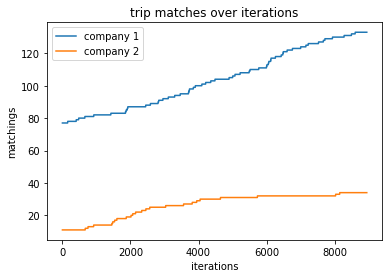

In [178]:
plt.plot(results['matchigs1'], label='company 1')
plt.plot(results['matchings2'], label='company 2')
plt.xlabel('iterations')
plt.ylabel('matchings')
plt.title('trip matches over iterations')
plt.legend()
plt.show()

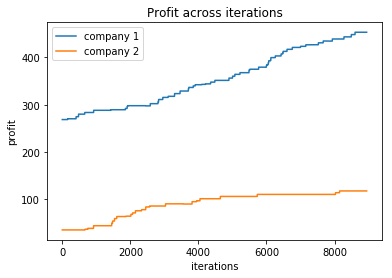

In [180]:
plt.plot(results['profits1'], label='company 1')
plt.plot(results['profits2'], label='company 2')
plt.xlabel('iterations')
plt.ylabel('profit')
plt.title("Profit across iterations")
plt.legend()
plt.show()


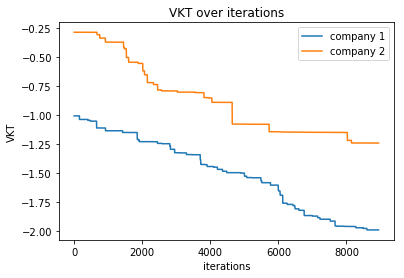

In [182]:
plt.plot(results['VKT1'], label='company 1')
plt.plot(results['VKT2'], label='company 2')
plt.xlabel('iterations')
plt.ylabel('VKT')
plt.title('VKT over iterations')
plt.legend()
plt.show()